--- Running Comparative Analysis for AMD ---


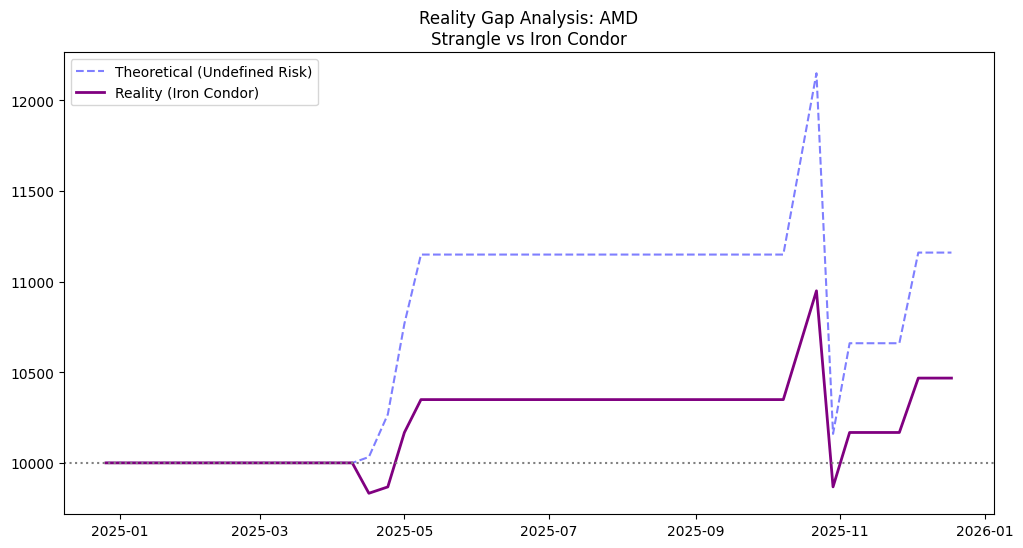

Theoretical Final: $11,160.04
Reality Final:     $10,467.74


In [6]:
# --- COPY THIS INTO A NEW CELL IN research.ipynb ---

import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import sys
import os

# --- PATH FIX: Add the parent directory to path so we can import config ---
# Use '..' if notebook is in a subfolder, or '.' if in root
sys.path.append(os.path.abspath('..')) 

try:
    import config
    TICKER_TO_TEST = config.TARGET_TICKER # Use the ticker from your config
except ImportError:
    # Fallback if config still not found
    print("⚠️ Could not import config. Using manual defaults.")
    TICKER_TO_TEST = "TSLA"

VOL_LOOKBACK = 20
VOL_THRESHOLD = 0.80

def run_comparative_analysis(ticker):
    print(f"--- Running Comparative Analysis for {ticker} ---")
    
    # 1. Fetch Data
    df = yf.download(ticker, period="1y", interval="1d", progress=False)
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    col_name = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
    df = df[[col_name]].copy()
    df.rename(columns={col_name: 'price'}, inplace=True)
    
    # 2. Calc Volatility
    df['returns'] = df['price'].pct_change()
    df['rolling_vol'] = df['returns'].rolling(window=VOL_LOOKBACK).std() * np.sqrt(252)
    df['vol_rank'] = df['rolling_vol'].rank(pct=True)
    
    # 3. Initialize Arrays
    capital_theoretical = 10000 # Old Strategy (Strangle)
    capital_reality = 10000     # New Strategy (Iron Condor)
    
    curve_theoretical = [10000]
    curve_reality = [10000]
    dates = [df.index[0]]
    
    days = list(df.index)
    
    # 4. Simulation Loop
    for i in range(VOL_LOOKBACK, len(days) - 5, 5): 
        current_date = days[i]
        future_date_idx = i + 5
        
        if future_date_idx < len(days):
            current_vol_rank = df.loc[current_date]['vol_rank']
            
            if current_vol_rank > VOL_THRESHOLD:
                # Trade Signal Active
                today_price = df.loc[current_date]['price']
                future_price = df.loc[days[future_date_idx]]['price']
                pct_move = abs(future_price - today_price) / today_price
                
                # --- LOGIC A: THEORETICAL (Short Strangle) ---
                prem_theo = 500
                if pct_move > 0.04:
                    loss = (pct_move - 0.04) * today_price * 100
                    pnl_theo = prem_theo - loss
                else:
                    pnl_theo = prem_theo
                capital_theoretical += pnl_theo
                
                # --- LOGIC B: REALITY (Iron Condor) ---
                prem_real = 300 # Less premium (wing cost)
                wing_width = 0.06 # Max loss cap
                
                if pct_move > 0.04:
                    raw_loss = (pct_move - 0.04) * today_price
                    max_loss_cap = wing_width * today_price
                    realized_loss = min(raw_loss, max_loss_cap) * 100
                    pnl_real = prem_real - realized_loss
                else:
                    pnl_real = prem_real
                capital_reality += pnl_real
                
            dates.append(days[future_date_idx])
            curve_theoretical.append(capital_theoretical)
            curve_reality.append(capital_reality)

    # 5. Plot
    plt.figure(figsize=(12, 6))
    plt.plot(dates, curve_theoretical, label='Theoretical (Undefined Risk)', color='blue', linestyle='--', alpha=0.5)
    plt.plot(dates, curve_reality, label='Reality (Iron Condor)', color='purple', linewidth=2)
    plt.axhline(y=10000, color='gray', linestyle=':')
    plt.title(f"Reality Gap Analysis: {ticker}\nStrangle vs Iron Condor")
    plt.legend()
    plt.show()
    
    print(f"Theoretical Final: ${capital_theoretical:,.2f}")
    print(f"Reality Final:     ${capital_reality:,.2f}")

# Run it
run_comparative_analysis(TICKER_TO_TEST)